# Hálózattudomány: Nagyházi
## Rajk Szakkollégium, 2020/2021 Tavasz

Kurzustartó: Kárpáti András, TA: Dormán Hanga

A notebook  Gyenes Márk és  Hobot Péter munkája

Az alábbiakban a cseh és szlovák  [Pokec](https://snap.stanford.edu/data/soc-Pokec.html) közösségi média hálózatát fogjuk kutatni. Kettős céllal állunk a dolgozat elé. Egyrészről leíró statisztikákon keresztül fogjuk bemutatni, hogy milyen tulajdonságai vannak a felhasználók kapcsolati hálójának. Másrészről szeretnénk bemutatni, hogy milyen módszerekkel tudunk becslést mondani a felhasználók nemére, kizárólag a közösségi hálózatban betöltött helyükből/szerepükből kiindulva. 

In [1]:
%run gyenes_hobot_hazi.py

In [2]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# 1. Importáljuk az adatot

In [3]:
df_node = pd.read_csv('soc-pokec-relationships.txt.gz', 
                                 header=None, sep='\t', quotechar='"')

In [4]:
df_attr=pd.read_csv('soc-pokec-profiles.txt.gz', compression='gzip', 
                                 header=None, sep='\t', quotechar='"', usecols=[0,3,4,7])

# 2. Gráf építés

#### A következő részben felépítünk egy gráfot, melyel tovább tudunk gráf attribútomokat számolni, mint a klaszterezettség mértéke vagy a fokszám eloszlás

In [5]:
#mintát veszünk a hatalmas networkből: 3 pozsonyi régiót
edge_list_attributes=minta(df_node, df_attr)

In [6]:
node_attributes=edge_list_attributes

In [7]:
G=nx.from_pandas_edgelist(node_attributes, "node_1", 'node_2')

In [8]:
node_attributes=node_attributes.set_index("node_1").drop_duplicates()

In [9]:
for node,data in G.nodes(data=True):
    try:
        data['gender_1'] = node_attributes.loc[node].iloc[0]["gender_1"]
    except:
        pass

In [10]:
for node,data in G.nodes(data=True):
    try:
        data['age_1'] = node_attributes.loc[node].iloc[0]["age_1"]
    except:
        pass

#### Kiválasztjuk a legnagyobb komponenst és azzal dolgozunk tovább. Azokra a feladatokra, melyekre az összes élet értelmes elemezni továbbra is edge_list_attributes nevű DataFramet használjuk: pl életkor és kapcsolatok összessége, vagy a felhasználó nemének a szoszédok nemének móduszán alapuló becslése.

In [11]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

### A következőkben a nodeok tulajdonságait keressük a gráfban, majd azokat építjük egy dataframe-é.

In [12]:
data=pd.DataFrame(G.nodes())
data.columns = ['Node']

In [13]:
data= generate_attribute_data(data, G)


In [14]:
data=triplets(data, G)

In [15]:
data

,Node,Gender,Age,Degree,Avg_Neighbor_Degree,Clustering_Coeff,Num_Triangles,FF,LL,FL
0,1381344.0,0.0,27.0,2,3.500,0.000000,0,0.0,0.0,0.0
1,3.0,NaN,NaN,1,2.000,0.000000,0,0.0,0.0,0.0
2,575150.0,1.0,27.0,8,7.875,0.000000,0,0.0,0.0,0.0
3,214.0,1.0,0.0,2,7.500,0.000000,0,0.0,0.0,0.0
4,983231.0,0.0,0.0,7,7.000,0.095238,2,0.5,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...
15509,1623133.0,NaN,NaN,1,26.000,0.000000,0,0.0,0.0,0.0
15510,1631922.0,NaN,NaN,1,2.000,0.000000,0,0.0,0.0,0.0
15511,1628054.0,NaN,NaN,1,3.000,0.000000,0,0.0,0.0,0.0
15512,1628244.0,NaN,NaN,1,15.000,0.000000,0,0.0,0.0,0.0


# 3. Hálózat analízis

#### A következőkben arra keressük a választ, hogy ki kivel barátkozik, melyik nemnek van több barátja és hogy a fiatalok vagy az öregek tartanak fenn több kapcsolatot. Story of our lives, ahogy az angol mondaná.

### Ki kivel barátkozik?

In [16]:
cross_age, cross_age_boys, cross_age_girls, cross_age_girls_boys = boys_and_girls(edge_list_attributes)

C:\Users\5480\Documents\NetworkScience\network_2021_spring\network_2021_spring\HAZIK\Hobot\gyenes_hobot_hazi.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_age["age_1"]=cross_age['age_1'].fillna(0)
C:\Users\5480\Documents\NetworkScience\network_2021_spring\network_2021_spring\HAZIK\Hobot\gyenes_hobot_hazi.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_age["age_2"]=cross_age['age_2'].fillna(0)
C:\Users\5480\Documents\NetworkScience\network_2021_spring\network_2021_spring\HAZIK\Hobot

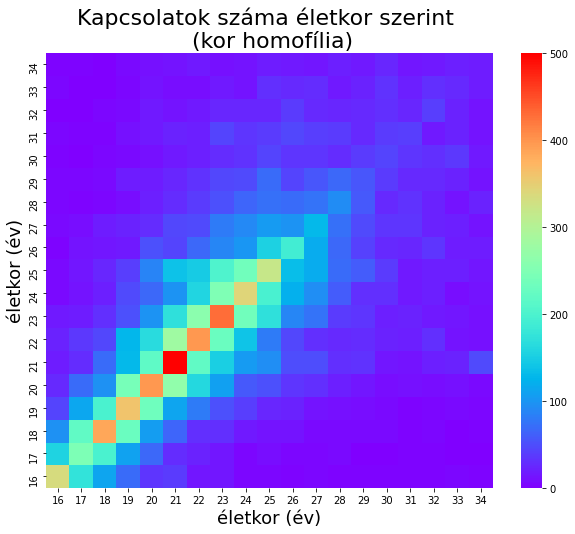

In [17]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))

#plt.sca(ax[0])
ax = sns.heatmap(cross_age, cmap="rainbow")
ax.set_title("Kapcsolatok száma életkor szerint \n (kor homofília)", fontsize=22)
ax.set_xlabel("életkor (év)", fontsize=18)
ax.set_ylabel("életkor (év)", fontsize=18)

ax.set_xticklabels([i for i in range(16, 35)])
ax.set_yticklabels([i for i in range(16, 35)])

ax.invert_yaxis()





### Ha a teljes populációt nézzük a kor-homofília elég erős kapcsolatot mutat: ugyanolyan idősekkel vannak kapcsolatban a Pokec használói

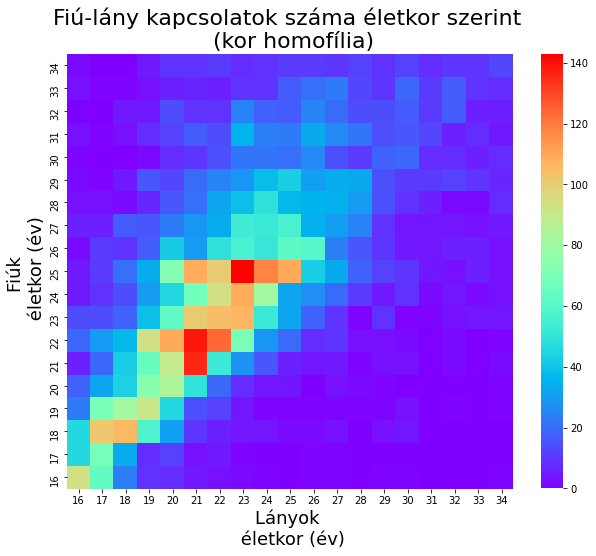

In [18]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))

#plt.sca(ax[0])
ax = sns.heatmap(cross_age_girls_boys, cmap="rainbow")
ax.set_title("Fiú-lány kapcsolatok száma életkor szerint \n (kor homofília)", fontsize=22)
ax.set_xlabel("Lányok \n életkor (év)", fontsize=18)
ax.set_ylabel("Fiúk \n életkor (év)", fontsize=18)

ax.set_xticklabels([i for i in range(16, 35)])
ax.set_yticklabels([i for i in range(16, 35)])

ax.invert_yaxis()

#### Látható, hogy 23 éves lányok sokan vannak kapcsolatban 25 éves fiúkkal a homofília, tehát egy kicsit átalakul: 1-2évvel idősebbek a fiúk a kapcsolatokban. 

## Klaszterek a hálózatban

In [19]:
bestcomm_dict=make_community(G)

Klaszterek száma: 42 Louvain modularitás: 0.658


#### A gráfban relatíven sok klaszter csoport van. Azonban nagyságrendileg ez nem probléma, mivel 15 ezer nodehoz alig pár tíz csoportot allokálunk.

In [20]:
#itt csak hozzáadjuk a klasztereket az attributumokat tartalmazó dataframehez
data=add_community(G, bestcomm_dict, data)

In [21]:
data

,Node,Gender,Age,Degree,Avg_Neighbor_Degree,Clustering_Coeff,Num_Triangles,FF,LL,FL,nodes,Community
0,1381344.0,0.0,27.0,2,3.500,0.000000,0,0.0,0.0,0.0,1381344.0,33
1,3.0,NaN,NaN,1,2.000,0.000000,0,0.0,0.0,0.0,3.0,33
2,575150.0,1.0,27.0,8,7.875,0.000000,0,0.0,0.0,0.0,575150.0,1
3,214.0,1.0,0.0,2,7.500,0.000000,0,0.0,0.0,0.0,214.0,1
4,983231.0,0.0,0.0,7,7.000,0.095238,2,0.5,0.5,0.0,983231.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15509,1623133.0,NaN,NaN,1,26.000,0.000000,0,0.0,0.0,0.0,1623133.0,17
15510,1631922.0,NaN,NaN,1,2.000,0.000000,0,0.0,0.0,0.0,1631922.0,16
15511,1628054.0,NaN,NaN,1,3.000,0.000000,0,0.0,0.0,0.0,1628054.0,27
15512,1628244.0,NaN,NaN,1,15.000,0.000000,0,0.0,0.0,0.0,1628244.0,9


## Vizualizációk

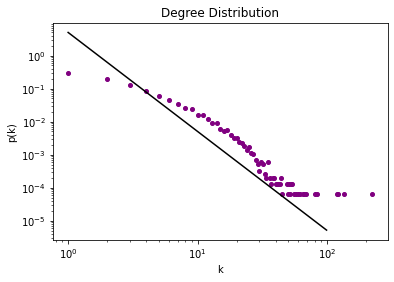

In [22]:
plot_degree_dist(G, fit_line=True, expct_lo=1, expct_hi=100, expct_const=5)

#### Az ábrán jól látszik, hogy a fokszám eloszlás hatványtörvényt követ. Ez a skálafüggetlen gráfok jellemzője.

### Hogyan alakulnak kapcsolataink életünk során?

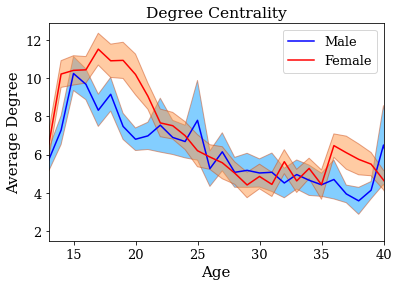

In [23]:
age_degree(data)

### A legnagyobb átlagos fokszámmal a fiatalok rendelkeznek.A fenti ábrából még az is kivehető, hogy fiatalon a lányok népszerűbbek, minta fiúk. Azonban ez a különbség a 30-es évekre eltűnik

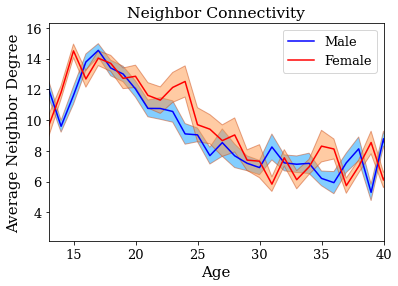

In [24]:
age_connect(data)

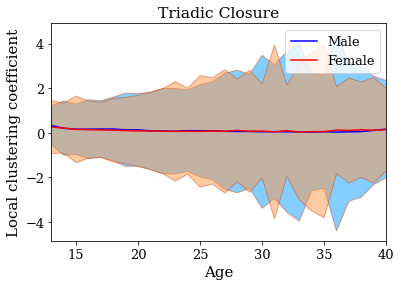

In [25]:
age_clustering(data)

# 4. Becslés: Hálózatból felhasználók nemét

### Első közelítésnek nézzük meg, hogy mi a neve a felhasználó szomszédainak azaz közösségi hálós kapcsolatainak

In [26]:
#itt még a szomszédokat tartalmazó edge_list_attributes dataframet használjuk, megkönyítve a helyzetet.
pred=mean_predict(edge_list_attributes)

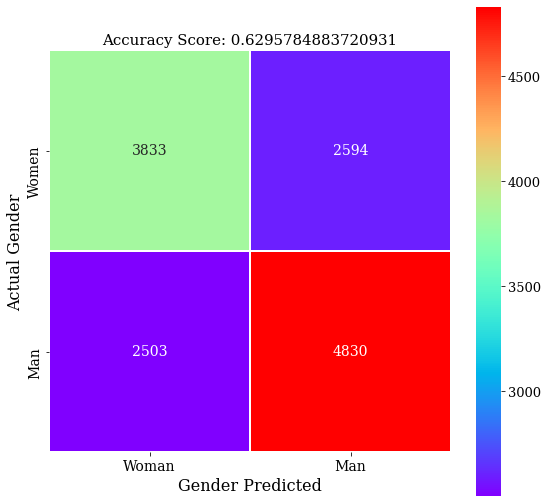

In [27]:
import seaborn as sns
from sklearn import  metrics
from sklearn import linear_model, model_selection
logistic = linear_model.LogisticRegression()

cm = metrics.confusion_matrix(pred["gender_1"],pred["predict"])

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'rainbow', annot_kws={"fontsize":14});
plt.yticks([0.5,1.5], labels=["Women", "Man"], fontsize=14)
plt.ylabel('Actual Gender', fontsize=16);
plt.xticks([0.5,1.5], labels=["Woman", "Man"], fontsize=14)
plt.xlabel('Gender Predicted', fontsize=16);

plt.title(f'Accuracy Score: {len(pred[pred["gender_1"]==pred["predict"]])/len(pred)}', size = 15);

### A szomszédok alapján történő prediktálás nem elég erős, hiszem 63 százalék körül tudjuk megmondani, hogy ki lehet fiú és ki lány. Ez mégis jobb, mint a random guess.

### Prediktáljuk a klaszter átlagát. Tehát másodjára nézzük meg, hogy a klaszterekben szereplő emberek nemének módusza jó közelítést ad-e a felhasználó nemére.

In [28]:
com_pred=community_pred(data)

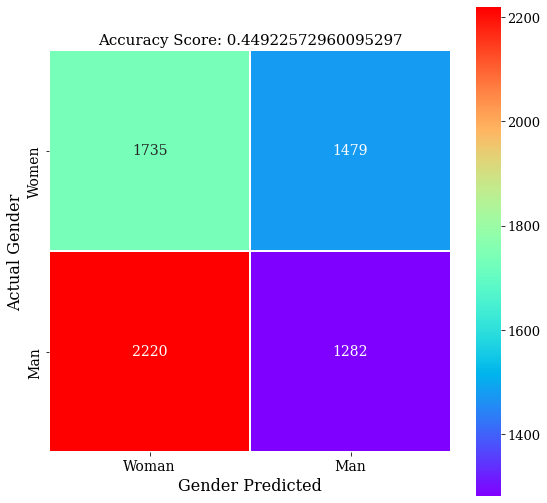

In [29]:
import seaborn as sns
from sklearn import  metrics
from sklearn import linear_model, model_selection
logistic = linear_model.LogisticRegression()

cm = metrics.confusion_matrix(com_pred["Gender"],com_pred["gender_com_pred"])

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'rainbow', annot_kws={"fontsize":14});
plt.yticks([0.5,1.5], labels=["Women", "Man"], fontsize=14)
plt.ylabel('Actual Gender', fontsize=16);
plt.xticks([0.5,1.5], labels=["Woman", "Man"], fontsize=14)
plt.xlabel('Gender Predicted', fontsize=16);

plt.title(f'Accuracy Score: {len(com_pred[com_pred["Gender"]==com_pred["gender_com_pred"]])/len(com_pred)}', size = 15);

### A klaszter átlaga kifejezetten rossz becslést nyújt a felhasználó nemére. Nem véletlen: feltehetően a mintavétel miatt sok az 2-3 csúccsal rendelkező klaszter, melyekben sok a fiú-lány kapcsolat, ami így kifejezetten 

In [30]:
trip_pred=triplet_pred(data)

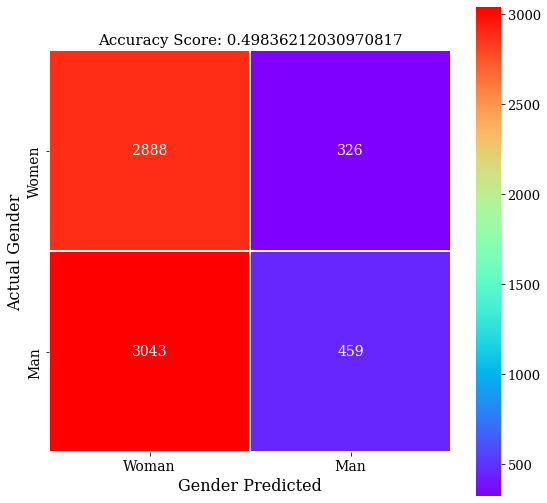

In [31]:
import seaborn as sns
from sklearn import  metrics
from sklearn import linear_model, model_selection
logistic = linear_model.LogisticRegression()

cm = metrics.confusion_matrix(trip_pred["Gender"],trip_pred["Gender_pred"])

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'rainbow', annot_kws={"fontsize":14});
plt.yticks([0.5,1.5], labels=["Women", "Man"], fontsize=14)
plt.ylabel('Actual Gender', fontsize=16);
plt.xticks([0.5,1.5], labels=["Woman", "Man"], fontsize=14)
plt.xlabel('Gender Predicted', fontsize=16);

plt.title(f'Accuracy Score: {len(trip_pred[trip_pred["Gender"]==trip_pred["Gender_pred"]])/len(trip_pred)}', size = 15);

### Gráf-attributumok által prediktálás

#### Az alábbiakban a gráfból szerzett minden attributumból próbálunk prediktálni nemet. Nehát kor, fokszám, szomszédok, klaszter koefficiens, tripletek és klaszterekből.

In [32]:
def data_target(data):
    pred_data=data[data["Gender"].notna()].reset_index()
    pred_data=pred_data.drop("Gender", axis=1)
    target=data[data["Gender"].notna()].reset_index()
    target=target["Gender"]
    return pred_data, target

In [33]:
pred_data, target = data_target(data)

In [34]:
from sklearn import linear_model, model_selection
from sklearn.model_selection import train_test_split


data_train, data_test, target_train, target_test = model_selection.train_test_split(
    pred_data, target, test_size=0.25, random_state=0)
len(data_train),len(data_test)

(5037, 1679)

In [35]:
#initialize the model
from sklearn import linear_model, model_selection, metrics
logistic = linear_model.LogisticRegression()

# fit the model
logistic.fit(data_train,target_train)

LogisticRegression()

In [36]:
print(f'LogisticRegression accuracy score: {logistic.score(data_test, target_test):.3f}')

LogisticRegression accuracy score: 0.518


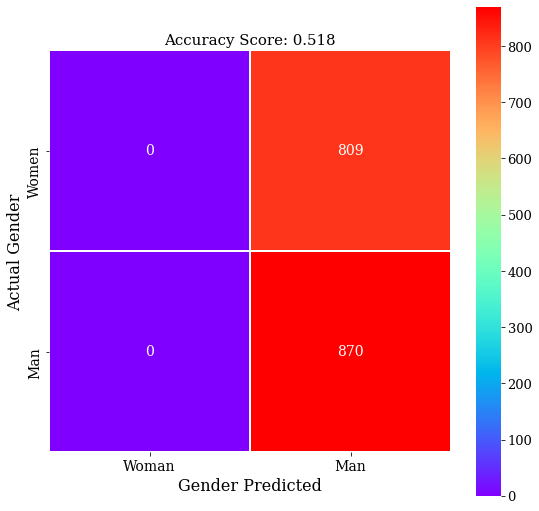

In [37]:
predictions = logistic.predict(data_test)
cm = metrics.confusion_matrix(target_test,predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'rainbow', annot_kws={"fontsize":14});
plt.yticks([0.5,1.5], labels=["Women", "Man"], fontsize=14)
plt.ylabel('Actual Gender', fontsize=16);
plt.xticks([0.5,1.5], labels=["Woman", "Man"], fontsize=14)
plt.xlabel('Gender Predicted', fontsize=16);
plt.title(f'Accuracy Score: {logistic.score(data_test, target_test):.3f}', size = 15);

## A fenti eredmény predikciós értelemben értelmezhetetlen. Mindenkinek férfit prediktált a modell, ami természetesen 50 százalék körüli eredményt ad. A legjobb predikciónk tehát a szomszédok átlaga lett.